# Cálculo del Centro de Masa de la Densidad de Fuentes de Corriente

En este *notebook* de Julia implementaremos métodos numéricos para llevar a cabo un análisis de *centro de masa* (promedio vectorial) de la densidad de pozos y fuentes de corriente sobre una rebanada del hipocámpo de una rata. 
Comenzaremos por tomar como ejemplo los datos obtenidos de un experimento con actividad epileptiforme.

In [1]:
muacamuaca=open("DatosActividadEpilepticaSelectos.bin", "r")

LoadError: opening file DatosActividadEpilepticaSelectos.bin: No such file or directory
while loading In[1], in expression starting on line 1

In [4]:
formaarray=(64,64,9101)

(64,64,9101)

# Este es un titular

In [5]:
Datos=read(muacamuaca, Float64, formaarray);

In [6]:
tmax=formaarray[3]


9101

In [7]:
close(muacamuaca)

Para este ejemplo recortaremos el arreglo de datos y nos centraremos en la parte con actividad más notoria:

In [8]:
#No todo es interesante. 
Datos=Datos[:,:,3500:8500]
tmax=size(Datos)[3]
formaarray=(64,64,tmax)

(64,64,5001)

In [26]:
#hay canales saturados con medidas brutalmente altos
map!(x-> abs(x)>1750? 0: x, Datos);

## Sección 1: Obtención de la densidad de fuentes de corriente (CSD)

Vamos a guardar la serie de tiempo de un electródo particular para comparar y hacer algunas gráficas.

In [27]:
#Ejemplo a comparar
SerieEjemplo=reshape(Datos[58,50,:], tmax)
writedlm("ExampleDatosLargos-58-50.dat", SerieEjemplo)

Una convolución con una Gaussiana de ancho adecuado es equivalente a un filtro pasabajos diferenciable. Implementaremos la convolución de forma que podamos eliminar el ruido de altas frecuencias intrínseco del aparato de medición (BioCAM4096).

In [54]:
function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

function GaussSuavizar(Datos,Sigma)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3*sigma
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(Datos)
    datoscolchon=vcat(colchon*Datos[1], Datos, colchon*Datos[end])
    kernel=map(x->UnNormGauss(x,Sigma), [-medioancho:medioancho])
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(Datos)-medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(Datos))
    b=maximum(abs(result))
    #nromalizacion 
    #result=result*a/b
    return result
end
    

GaussSuavizar (generic function with 1 method)

Usemos PyPlot para ver el efecto de nuestro filtro pasabajos.

In [102]:
using PyPlot

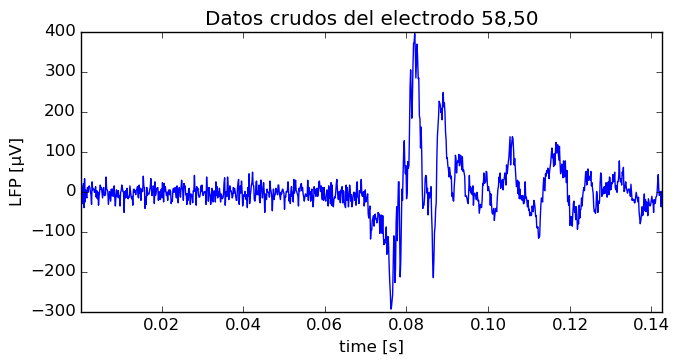

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff32fd375c0>

In [55]:
tiempo=1:1001
t=700
tit="Datos crudos del electrodo 58,50"
figure(figsize=(7.5,3.5))
PyPlot.xlim(1/7022,1001/7022)
xlabel("time [s]")
ylabel("LFP [µV]")
title(tit)
plot(tiempo/7022,SerieEjemplo[1:1001])

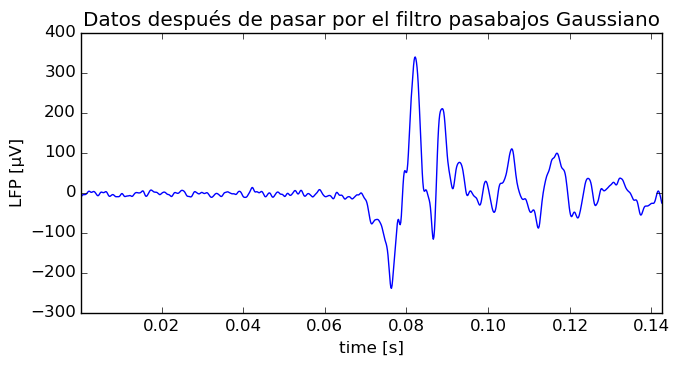

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff32fdbdda0>

In [56]:
SerieEjemploSuave=GaussSuavizar(SerieEjemplo,7)
tiempo=1:1001
t=700
tit="Datos después de pasar por el filtro pasabajos Gaussiano"
figure(figsize=(7.5,3.5))
PyPlot.xlim(1/7022,1001/7022)
xlabel("time [s]")
ylabel("LFP [µV]")
title(tit)
plot(tiempo/7022,SerieEjemploSuave[1:1001])

Procedemos a usar el filtro en todos el arreglo:

In [57]:
LFPSuave=zeros(Datos);
for j=1:64, k=1:64
    LFPSuave[j,k,:]=GaussSuavizar(reshape(Datos[j,k,:],tmax),7)
end

Ahora, dado que el operador Laplaciano numérico es *extremadamente* sensible a los bordes, es necesario suavizar éstos. Dicho de otra forma, tenemos que eliminar el ruido espacial proveniente de la geometría y resolución del aparato. De forma similar a lo llevado a cabo anteriormente, haremos una convolución con una Gaussiana del 3 y medio píxeles de ancho (*Gaussian blur*).

In [15]:
GaussianKernel=readdlm("GaussianMatrix.dat")

7x7 Array{Float64,2}:
 6.7e-7      2.292e-5    0.00019117  …  0.00019117  2.292e-5    6.7e-7    
 2.292e-5    0.00078634  0.00655965     0.00655965  0.00078633  2.292e-5  
 0.00019117  0.00655965  0.0547216      0.0547216   0.00655965  0.00019117
 0.00038771  0.0133037   0.110982       0.110982    0.0133037   0.00038771
 0.00019117  0.00655965  0.0547216      0.0547216   0.00655965  0.00019117
 2.292e-5    0.00078633  0.00655965  …  0.00655965  0.00078633  2.292e-5  
 6.7e-7      2.292e-5    0.00019117     0.00019117  2.292e-5    6.7e-7    

In [58]:

function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,1])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #Esta convolución no respeta norma L2
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end

GaussianSmooth (generic function with 1 method)

In [59]:
LFPplanchado=zeros(formaarray)
for t=1:tmax
    LFPplanchado[:,:,t]=GaussianSmooth(LFPSuave[:,:,t])
end

In [64]:
# Guardamos los datos obtenidos hasta ahora, por cuadro
for t=1:tmax
#    aux=map(x-> isnan(x)?0:x, Chumbaganga[:,:,t])
    zacatlan="./GarbageCollector/LFP_GausFiltered_AE-$t.dat"
    writedlm(zacatlan, LFPplanchado[:,:,t])
end


Procedemos ahora a implementar un operador Laplaciano discreto. La forma que se aproxima más al caso ideal invariante ante rotaciones es la propuesta por T. Lindberg (1990, 1994). Esto evita efectos de "cruz" debidos a la estructura del arreglo de microelectrodos.

In [74]:
#checa que Julia va ordenando los datos renglon por renglon, no columna por columna
LaplacianTerm1=[[0 1 0], [1 -4 1], [0 1 0]]
LaplacianTerm2=[[0.5 0 0.5], [0 -2 0], [0.5 0 0.5]]
LaplacianKernel=(1-1/3)*LaplacianTerm1+(1/3)*LaplacianTerm2

function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo+1, k=2:ancho+1
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j-1,k-1]=sum(LaplacianKernel.*aux)
    end
    return result
end

DiscreteLaplacian (generic function with 1 method)

Ahora usaremos la aproximación ohmica, homogénea e isotrópica, donde la densidad de fuentes de corriente es proporcional a el Laplaciano del potencial de campo local,
$$I_m \propto -\nabla^2 \phi$$

In [75]:
CSD=zeros(formaarray)
for t=1:tmax
    CSD[:,:,t]=DiscreteLaplacian(-LFPplanchado[:,:,t])
end

Hagamos un par de comparaciones. Como se ven ANTES y DESPUES del filtro Laplaciano.

In [125]:
puntox=[44,48,52,54,58, 63]
puntoy=[38,42,45,47,50, 54]
puntol=["F","E", "D", "C", "B","A"]

6-element Array{ASCIIString,1}:
 "F"
 "E"
 "D"
 "C"
 "B"
 "A"

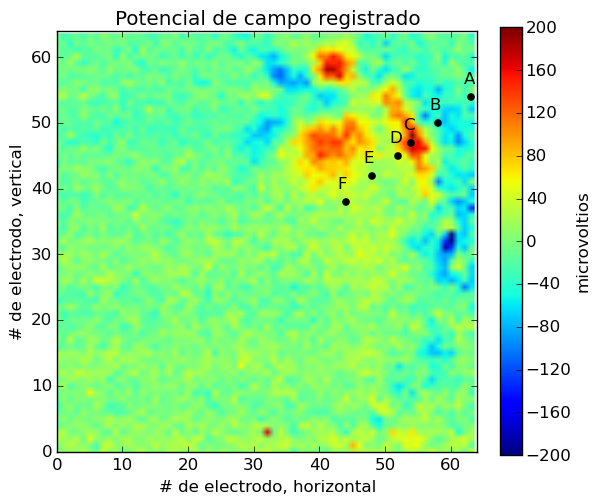

PyObject <matplotlib.text.Text object at 0x7ff336edb2e8>

In [198]:
figure(figsize=(6,6))
title("Potencial de campo registrado")
limites=100
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)

imagen=imshow(Datos[:,:,599], cmap="jet", origin="lower", vmin=-2*limites,vmax=2*limites)
scatter(puntox,puntoy, marker="o", s=20, c="black")
for punto in 1:6
    annotate(puntol[punto], (puntox[punto], puntoy[punto]), xytext=(-5,10), textcoords="offset points")
end
#otraimagen=imshow(Laplaganga[:,:,1999], cmap="gist_heat", origin="lower")
cbx=colorbar(imagen, fraction=0.046) 
cbx[:set_label]("microvoltios")
xlabel("# de electrodo, horizontal")
ylabel("# de electrodo, vertical")
#savefig("LFP_jet_experimentaldataconpuntos_599.png",dpi=90)
#origin lower sigue la convención gnuplot. Origen abajo izquierda. La otra sigue la convención matrix (default).

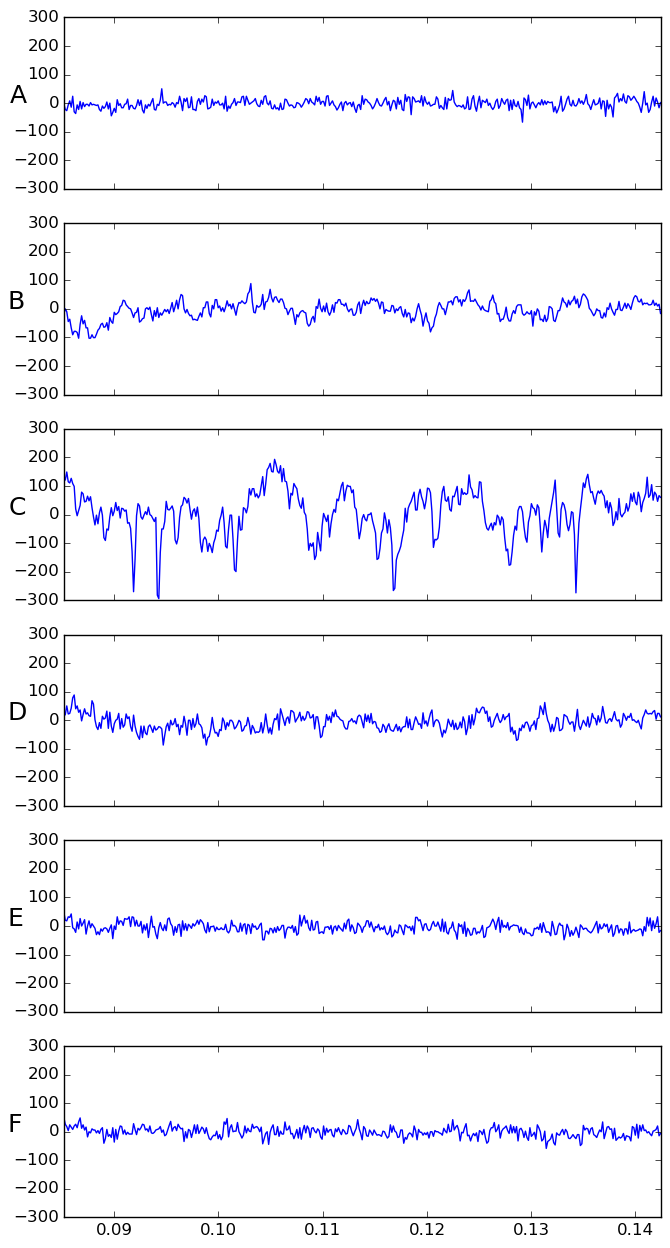

In [196]:
tiempo=598:1000
t=700

farofa, lista=subplots(6, sharex=true, sharey=true, figsize=(7.7,6*2.5))

for j=1:6
    PyPlot.xlim(598/7022,1000/7022)
    PyPlot.ylim(-300,300)
    lista[j][:plot](tiempo/7022,vec(Datos[puntoy[7-j],puntox[7-j],tiempo]))
    lista[j][:annotate](puntol[7-j],xy=(0.08,0), annotation_clip=false, fontsize=18)
end
savefig("IntentoPotencialesMedidos1.svg",dpi=90)

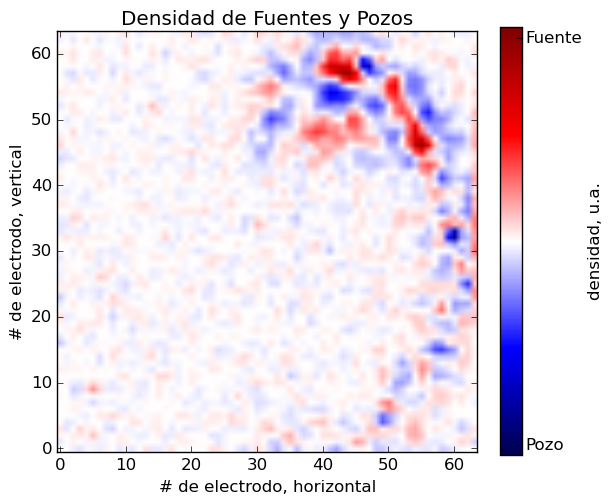

In [116]:
figure(figsize=(6,6))
#tight_layout()
title("Densidad de Fuentes y Pozos")
limites=80
#imagen=imshow(DatosLimpios[:,:,599], cmap="gist_heat", origin="lower")
otraimagen=imshow(CSDAplanado[:,:,599], cmap="seismic", origin="lower", vmin=-limites,vmax=limites)
cb=colorbar(otraimagen, fraction=0.046, ticks=[-limites*0.95, limites*0.95])
xlabel("# de electrodo, horizontal")
ylabel("# de electrodo, vertical")
cb[:set_label]("densidad, u.a.")
cb[:set_ticklabels]([{"Pozo"}, {"Fuente"}])
savefig("CSD_599.svg",dpi=90)

In [84]:
CSDAplanado[:,:,599]

64x64 Array{Real,2}:
  0         0        -2.74078  -4.39502  …  -1.02278   0         0      
 -3.3232    0         2.19949   0            6.45618   3.83577  -6.89766
  1.47622   0         2.64164   3.47259      3.07359   3.92081   2.4971 
  4.37351  -3.84213   0         7.11361     -9.26111  -4.49276   4.11362
  0        -3.83367  -2.994     0           -6.68711  -2.57213   0      
  0         0         0        -1.70576  …   0         0         0      
  0         0         2.26616   1.50477      0         0         0      
  0         0         1.51851   1.86015      3.52381   0        -2.30306
  1.18546   0        -3.79254  -2.47694      4.59666   1.36563  -1.18893
  0         0        -7.6646   -5.44506      0         3.15178   1.41112
  0         1.78667  -2.88046  -3.65521  …  -5.67534   1.86936   2.45891
  0         0         0         0           -3.43828   0         0      
  2.59407   1.28241   1.36036   1.26518      5.09244   2.95221   1.56596
  ⋮                           

In [83]:
#Quitemos los datos menores a nuestro error numérico
CSDAplanado=map(x->abs(x)<0.99? 0:x, CSD); 

In [92]:
#Guardamos los datos obtenidos, porfavor.
for t=1:tmax
    zacatlan="GarbageCollector/CSD-$t.dat"
    writedlm(zacatlan, CSDAplanado[:,:,t])
end

##Sección 2: Obtención de los componentes disjuntos.

Los pozos y fuentes tienen una separación cualitativa clara con significado físico: el signo. Esto nos permite separar la densidad de fuentes y pozos en dos conjuntos separados, claramente, el conjunto de todos los pozos y el conjunto de todas las fuentes. Si establecemos un criterio umbral mayor al error numérico, esto separa por una banda ancha los dos conjuntos, y podemos separar cada conjunto en sus *componentes disconexas"*. Esto nos permitirá trazar trayectorias de actividad coherente **justamente** sobre las estructuras fisiológicas involucradas solamente.

Primero, para poder separar las componentes disjuntas, definiremos la 8-vecindad de un electrodo como el conjunto de todos los electrodos a su alrededor inmediato:

In [16]:
function vecindad8(punto::Array)
    j=punto[1]
    k=punto[2]
    result=Set{Array{Int64,1}}()
    push!(result, [j-1,k-1])
    push!(result, [j-1,k])
    push!(result, [j-1,k+1])
    push!(result, [j,k-1])
    push!(result, [j,k+1])
    push!(result, [j+1,k-1])
    push!(result, [j+1,k])
    push!(result, [j+1,k+1])
    return result
end
    

vecindad8 (generic function with 1 method)

Procedemos ahora a separar los componentes disjuntos: si un punto es detectado como pozo o fuente dependiendo de su signo, y los vecinos inmediatos también lo son, pertenece al mismo componente, en cambio, si sus vecinos son del signo opuesto o valen cero, entonces es elemento de la frontera.

In [17]:
Pozo=Array{Int16}[]
Fuente=Array{Int16}[]
CuentaFuentes=zeros(64,64);
CuentaPozos=zeros(64,64);
#El mismo ejemplo graficado anteriormente
for j=1:64, k=1:64
    if(CSD[j,k,1999]<-0.0)      
        push!(Pozo, [j, k])
        CuentaPozos[j,k]+=1
    elseif(CSD[j,k,1999]>0.0) 
        push!(Fuente, [j, k])
        CuentaFuentes[j,k]+=1
    end             
end


Ahora implementemos el llamado pase simple para separar las componentes de cada uno de los dos conjuntos.

In [18]:
#Simple pass method
lista=copy(Fuente)
curlab=0
componentes=Set{Any}()
while(length(lista)!=0)
    x=pop!(lista) #arranca el ULTIMO elemento de la lista
    listaprofundeza=Array{Int64}[]
    componentecurlab=Array{Int64}[]
    push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
    push!(componentecurlab, x)    
    profundidad=0
    while ((length(listaprofundeza)!=0) && profundidad<100)
        y=pop!(listaprofundeza)
        for v in vecindad8(y)
                if in(v, lista)
             #   println(indexin({v},lista), v)
                deleteat!(lista, indexin({v}, lista))
            #    println(v, "si estaba en la lista")
             #   println(lista)
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                else
                    #println(v, "no estaba en la lista")
                end
            end
    end
    # println("Para ", x, "la profundidad fue ", profundidad)
    curlab+=1
    push!(componentes, componentecurlab)
end
curlab

81

Para cada componente podemos obtener su "centro de masa", es decir, un promedio vectorial usando como función de peso la densidad de corriente absoluta detectada en cada punto y sus coordenadas en la matriz como vector. Simutaneamente obtendremos la *"masa"* de ese mismo componente, es decir, la densidad de corriente que  sume/surge de ese pozo/fuente en este instante de tiempo dado.

In [19]:
centrosdemasa=[[0 0 0];]
for p in componentes
    masa=0.00
    x=0.00
    y=0.00
    for q in p
        j=q[1]
        k=q[2]
        masalocal=CSD[j,k,1999]
        masa+=masalocal
        x+=k*masalocal
        y+=j*masalocal
    end
    x/=masa
    y/=masa
    A=[x y masa]
    centrosdemasa=vcat(centrosdemasa, A)
end
centrosdemasa=centrosdemasa[2:end,:];

Procedamos dibujar los *centros de masa* de los componentes disjuntos. Dibujemos un círculo centrado en el mismo *centro de masa* y con area proporcional a la *masa*, es decir a la densidad integrada sobre ese componente.

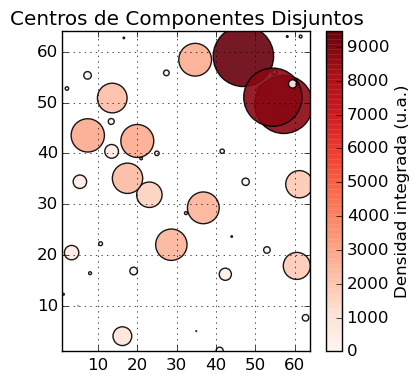

In [27]:
figure(figsize=(4,4))
title("Centros de Componentes Disjuntos")
xlim(1,64)
ylim(1,64)
imagen=scatter(centrosdemasa[:,1], centrosdemasa[:,2], 
c=centrosdemasa[:,3], s=abs(0.2*centrosdemasa[:,3]), cmap="Reds", 
alpha=0.9)
cb=colorbar(imagen)
cb[:set_label]("Densidad integrada (u.a.)")
grid()

A pesar de que hay en este ejemplo fuentes significativas fuera de CA y GD, las mayores componentes están claramente localizadas dentro del CA. Las fuentes fuera de los cuerpos neuronales deben mostrar trayectorias erráticas una vez que integremos las imagenes correspondientes en el tiempo, mientras que aquellas debidas a potenciales de acción o actividad evocada deben seguir trayectorias sobre los cuerpos neuronales involucrados. Una función auxiliar nos eliminará los "centros de masa" que sean de "masa" demasiado pequeñas.

In [20]:
function DropPeques(data)
    #solo funciona con data de dos indices.
    renglones,colus=size(data)
    prom=mean(abs(data[3]))
    result=zeros(1,colus)
    for k=1:renglones
        if abs(data[k,3])>prom
            result=vcat(result,data[k,:])
        end
    end
    return result
end

DropPeques (generic function with 1 method)

Dibujemos un ejemplo de un momento dado. El método que resuelve esto para el arreglo completo está en la última celda de código de este *notebook*.

In [29]:
t=1999
EjemploCentrosCSDPos=readdlm("GarbageCollector/CMPosLapla-$t.dat")
EjemploCentrosCSDPos=DropPeques(EjemploCentrosCSDPos)
xxpos=EjemploCentrosCSDPos[:,1]
yypos=EjemploCentrosCSDPos[:,2]
valorpos=EjemploCentrosCSDPos[:,3]
EjemploCentrosCSDNeg=readdlm("GarbageCollector/CMNegLapla-$t.dat")
EjemploCentrosCSDNeg=DropPeques(EjemploCentrosCSDNeg)
xxneg=EjemploCentrosCSDNeg[:,1]
yyneg=EjemploCentrosCSDNeg[:,2]
valorneg=EjemploCentrosCSDNeg[:,3];
CSDEjemplo=readdlm("GarbageCollector/CSD-$t.dat");

LoadError: opening file GarbageCollector/CMPosLapla-1999.dat: No such file or directory
while loading In[29], in expression starting on line 2

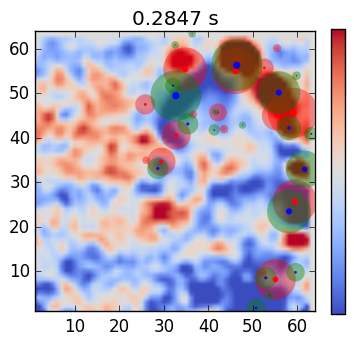

In [46]:
PyPlot.ion()
#################
seg=round(t/7022, 4)
titulo="$seg s"
figure(figsize=(4,4))
PyPlot.xlim(1,64)
PyPlot.ylim(1,64)

otraimagen=imshow(CSDEjemplo, cmap="coolwarm", origin="lower", vmin=-70, vmax=70)
cb=colorbar(otraimagen, fraction=0.046, ticks=[-150, 150])
cb[:set_ticklabels]([{"Pozo"}, {"Fuente"}])
scatter(xxpos,yypos, s=valorpos, alpha=0.4, c="r", edgecolors="none")
scatter(xxneg, yyneg, s=abs(valorneg), alpha=0.4, c="g", edgecolors="none")
scatter(xxpos,yypos, s=0.02*valorpos, alpha=0.9, c="r", edgecolors="none")
scatter(xxneg, yyneg,s=0.02*abs(valorneg), alpha=0.9, c="b", edgecolors="none")

title(titulo);

En la imágen superior los *"centros de masa"* para pozos (azul) y fuentes (rojo) están indicados con círculos pequeños, mientras que su masa integrada corresponde al área del círculo transparente alredeedor. El código de la última celda resuelve este problema secuencialmente para todos los *timeframes*. 

In [24]:
function ObtenComponentesYEscribe(Datos::Array, tini=1, tfini=tmax)

 for t=tini:tfini
    #iniciar variables vacias
    ActividadNegativa=Array{Int16}[]
    ActividadPositiva=Array{Int16}[]
    SpikeCountPositivo=zeros(64,64)
    SpikeCountNegativo=zeros(64,64)
    #Todos
    for j=1:64, k=1:64
            if(Datos[j,k,t]<-0.0)     
            push!(ActividadNegativa, [j, k])
            SpikeCountNegativo[j,k]+=1
                elseif(Datos[j,k,t]>0.0)
            push!(ActividadPositiva, [j, k])
            SpikeCountPositivo[j,k]+=1
        end             
    end

    #Simple pass method
    listaneg=copy(ActividadNegativa)
    listapos=copy(ActividadPositiva)
    componentesneg=Set{Any}()
    componentespos=Set{Any}()
    #Primero lo negativo (pozos)
    while(length(listaneg)!=0)
        x=pop!(listaneg) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<100)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listaneg)
             #   
                    deleteat!(listaneg, indexin({v}, listaneg))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentesneg, componentecurlab)
    end


    centrosdemasaneg=[[0 0 0];]
    for p in componentesneg
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
                masalocal=Datos[j,k,t]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasaneg=vcat(centrosdemasaneg, A)
    end
    centrosdemasaneg=centrosdemasaneg[2:end,:]
    zacatlan="GarbageCollector/CMPozos-$t.dat"
    writedlm(zacatlan, centrosdemasaneg)
    ##### Ahora lo posittivo (fuentes)
    while(length(listapos)!=0)
        x=pop!(listapos) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<100)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listapos)
             #   
                    deleteat!(listapos, indexin({v}, listapos))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentespos, componentecurlab)
    end


    centrosdemasapos=[[0 0 0];]
    for p in componentespos
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
                masalocal=Datos[j,k,t]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasapos=vcat(centrosdemasapos, A)
    end
    centrosdemasapos=centrosdemasapos[2:end,:]
    zacatlan="GarbageCollector/CMFuentes-$t.dat"
    writedlm(zacatlan, centrosdemasapos)
end
    return curlab
end

ObtenComponentesYEscribe (generic function with 3 methods)

In [27]:
@time ObtenComponentesYEscribe(CSD, 101,1000)

LoadError: interrupt
while loading In[27], in expression starting on line 56